In [2]:
from google.colab import drive
from collections import defaultdict
import os
import sys
import textwrap
from pathlib import Path
from typing import List, Dict, Union, Tuple, Generator
import torch
import pandas as pd
import numpy as np
import regex as re
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from timeit import default_timer as Timer

In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.chdir("/content/drive/MyDrive/Thesis/scripts")
os.getcwd()

'/content/drive/MyDrive/Thesis/scripts'

In [5]:
sys.path.append('/content/drive/MyDrive/Thesis/scripts')
from data_rnn import load_imdb

## 1. Load and inspect the data

Notes on `load_imdb()`:
* If final is **true**, the function returns the **canonical test/train split** with 25 000 reviews in each.
* If final is **false**, a **validation split** is returned with 20 000 training instances and 5 000
validation instances.

In [6]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [7]:
len(x_train), len(y_train)

(20000, 20000)

In [8]:
len(x_val), len(y_val)

(5000, 5000)

### 1.1 Functions (Week 1)

In [9]:
def create_batches(data: List[List[int]], labels: List[int]) -> List[List[List[int]]]:
  """
  Takes list of reviews and labels and turns them into batches of labels and reviews of uniform length.
  Params
    data: A list of reviews.
    labels: A list of labels
  Returns
    A list of batches containing reviews, each padded to ensure uniform length.
  """
  data, labels = data.copy(), labels.copy()
  data_and_labels = zip(data,labels)

  # Sorts the data from longest to shortest reviews and unzips data from labels
  data, labels = list(zip(*sorted(data_and_labels,
                             key=lambda x: len(x[0]),
                             reverse=True)
  ))

  data_batch: List[List[int]] = []
  label_batch: List[int] = []

  data_batches: List[List[List[int]]] = []
  label_batches: List[List[int]] = []

  curr_review_length: int = 0


  # Determines the size of the longest review
  max_tokens: int = max(len(review) for review in data)

  # loop over the list of reviews (x_train)
  for review_idx in range(len(data)):
    curr_review: List[int] = data[review_idx]
    curr_label: int = labels[review_idx]
    num_tokens: int = sum(len(review) for review in data_batch) # Calculate the number of tokens in the data_batch

    # If data_batch is empty add a review and set current review length
    if num_tokens == 0:
      data_batch.append(curr_review)
      label_batch.append(curr_label)
      curr_review_length = len(curr_review)

    # If the number of tokens in a data_batch exceed the limit or adding an extra token of the same size exceeds the limit:
    elif (num_tokens >= max_tokens) or (num_tokens + curr_review_length >= max_tokens):
      # Add the current data_batch to the list of data_batches
      data_batches.append(data_batch)
      label_batches.append(label_batch)
      # Create an empty data_batch for the next reviews
      data_batch = []
      label_batch = []
      # Append current review to new data_batch
      data_batch.append(curr_review)
      label_batch.append(curr_label)
      # Reset current review length
      curr_review_length = len(curr_review)

    else:
      padding = curr_review_length - len(curr_review) # Calculate padding needed for next token
      curr_review += padding * [0] # Add padding to next token
      data_batch.append(curr_review) # Add a review to the data_batch list
      label_batch.append(curr_label)

  # Ensures that the final data_batch is also added.
  if data_batch:
    data_batches.append(data_batch)
    label_batches.append(label_batch)

  return data_batches, label_batches

#################################################################################

def read_review(review: List[int])-> None:
  """
  Takes a list of integers as input and prints their string representation.
  Params:
    review: A list of integers.
  Returns:
    None
  """
  print(textwrap.fill(" ".join([i2w[word] for word in review]), 100),)

##################################################################################

def show_batches(data_batches, label_batches,
                 batch_num: int = 0,
                 print_reviews: bool = True) -> None:
  """
  Filler.
  """
  class_name = ['Positive', 'Negative']

  num_data_batches  = len(data_batches)
  num_label_batches = len(label_batches)

  data_batch  = data_batches[batch_num]
  label_batch = label_batches[batch_num]

  num_tokens = sum(len(review) for review in data_batch)

  review_length = len(data_batch[0])

  # check if reviews are all the same size
  same_size = max(len(review) for review in data_batch) == min(len(review) for review in data_batch)


  print(f"Number of data batches: {num_data_batches} | Number of label batches {num_label_batches}",
        f"\nBatch number: {batch_num}"
        "\n____________________________________________\n")
  print(f"Number of tokens in batch: {num_tokens}")
  print(f"Review length: {review_length}",
        f"\nReviews are the same size: {same_size}")
  print(f"Data batch size: {len(data_batch)} | Label batch size: {len(label_batch)}",
        "\n_____________________________________________\n")

  if print_reviews:
    for review, label in zip(data_batch, label_batch):
      read_review(review)
      print(f'\nLabel: {class_name[label]}', "\n------------------------------------")

#############################################################################################

def data_to_tensor_batch(data: List[list[int]],
                         labels: List[int],
                         device: str) -> Tuple[Generator[torch.Tensor, None, None], Generator[torch.Tensor, None, None]] :
  """
  Filler.
  """
  x_batches, y_batches = create_batches(data, labels)
  x_batched_tensors = (torch.tensor(batch, dtype=torch.long, device=device) for batch in x_batches)
  y_batched_tensors = (torch.tensor(batch, dtype=torch.long, device=device) for batch in y_batches)

  return x_batched_tensors, y_batched_tensors



def accuracy_fn(y_pred, y_true):
    """Calculates accuracy between truth labels and predictions.

    Params:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model,
               train_data,
               loss_fn,
               accuracy_fn,
               optimizer,
               device):
  """
  """

  # Set model to device and evaluation mode

  model.train()

  train_loss, train_acc = 0, 0

  for X, y in train_data:
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_logits = model(X) # Output is raw logits
    y_preds = y_logits.argmax(dim=1) # Turns logits into predictions

    # 2.1 Calculate Loss and Accuracy
    loss = loss_fn(y_logits,
                  y)
    acc = accuracy_fn(y_pred=y_preds,
                            y_true=y)

    # 2.2 Accumulate Loss and Accuracy
    train_loss += loss.item()
    train_acc += acc

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Step
    optimizer.step()

  train_loss /= len(train_data)
  train_acc /= len(train_data)

  print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train accuracy {train_acc:.2f}%")


############################################################################


def test_step(model,
              test_data,
              loss_fn,
              accuracy_fn,
              device):
  '''
  '''
  # Set model to device and evaluation mode

  model.eval()



  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X, y in test_data:
      X, y =  X.to(device), y.to(device)

      # 1. Forward Pass
      y_logits = model(X) # Output is raw logits
      y_preds = y_logits.argmax(dim=1) # Turns logits into predictions

      # 2.1 Calculate Loss and Accuracy
      loss = loss_fn(y_logits,
                    y)
      acc = accuracy_fn(y_pred=y_preds,
                        y_true=y)
      # 2.2 Accumulate Loss and Accuracy
      test_loss += loss.item()
      test_acc += acc

    test_loss /= len(test_data)
    test_acc /= len(test_data)
    print(f"Epoch: {epoch} | Test loss: {test_loss:.4f} | Test accuracy {test_acc:.2f}%")


###################################################################################

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

### 1.2 Models (Week 1)

In [10]:
class GlobalMeanPooling(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    """Extracts the mean across the time (sequence) dimension and returns the values of the embedded vector.
    """
    return torch.mean(x, dim=1)

#########################################################


class SentimentClassificationModelV1(nn.Module):

  def __init__(self, vocab_size, emb_size, output_shape):
    """
    Params
      vocab_size: The size of the vocabulary.
      emb_size: The size of the embedding vector
      output_shape:
    """
    super().__init__()
    self.sequence = nn.Sequential(nn.Embedding(num_embeddings=vocab_size, # Convert the integer indices to embedding vectors
                                               embedding_dim=emb_size,
                                               padding_idx=0),
                                  GlobalMeanPooling(), # Global max pooling along sequence dimension
                                  # nn.ReLU(),
                                  nn.Linear(in_features=emb_size, # Project down to the number of classes
                                  out_features=output_shape)
                                  )


  def forward(self, x):
    return self.sequence(x)

## 2. Adding Simple self attention

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
VOCAB_SIZE = len(i2w)
EMB_SIZE = 300

In [13]:
x_train_gen, y_train_gen = data_to_tensor_batch(x_train,
                                                y_train,
                                                device)

Xy_train_set = list(zip(x_train_gen, y_train_gen))

In [14]:
x_val_gen, y_val_gen = data_to_tensor_batch(x_train,
                                            y_train,
                                            device)

Xy_val_set = list(zip(x_val_gen, y_val_gen))

In [15]:
embedding = nn.Embedding(num_embeddings=VOCAB_SIZE,
                         embedding_dim=EMB_SIZE,
                         padding_idx=0
                         )
embedding.to(device)

Embedding(99430, 300, padding_idx=0)

In [16]:
test_tokens = Xy_val_set[-1][0]
test_tokens.shape

torch.Size([53, 34])

In [17]:
vector_tokens = embedding(test_tokens)[0]
vector_tokens.shape, vector_tokens.T.shape

(torch.Size([34, 300]), torch.Size([300, 34]))

In [18]:
weights_hat = torch.matmul(vector_tokens, vector_tokens.T)
weights_hat

tensor([[272.7883, -22.8565,  -9.1315,  ...,   0.0000,   0.0000,   0.0000],
        [-22.8565, 334.4389, -10.1668,  ...,   0.0000,   0.0000,   0.0000],
        [ -9.1315, -10.1668, 291.0109,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [19]:
weights = torch.softmax(weights_hat, dim=1)
weights.shape, weights[27]

(torch.Size([34, 34]),
 tensor([0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
         0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
         0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
         0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294],
        device='cuda:0', grad_fn=<SelectBackward0>))

In [20]:
output_y = torch.matmul(weights, vector_tokens)
output_y.shape

torch.Size([34, 300])

# Simple Self attention: Attention weights



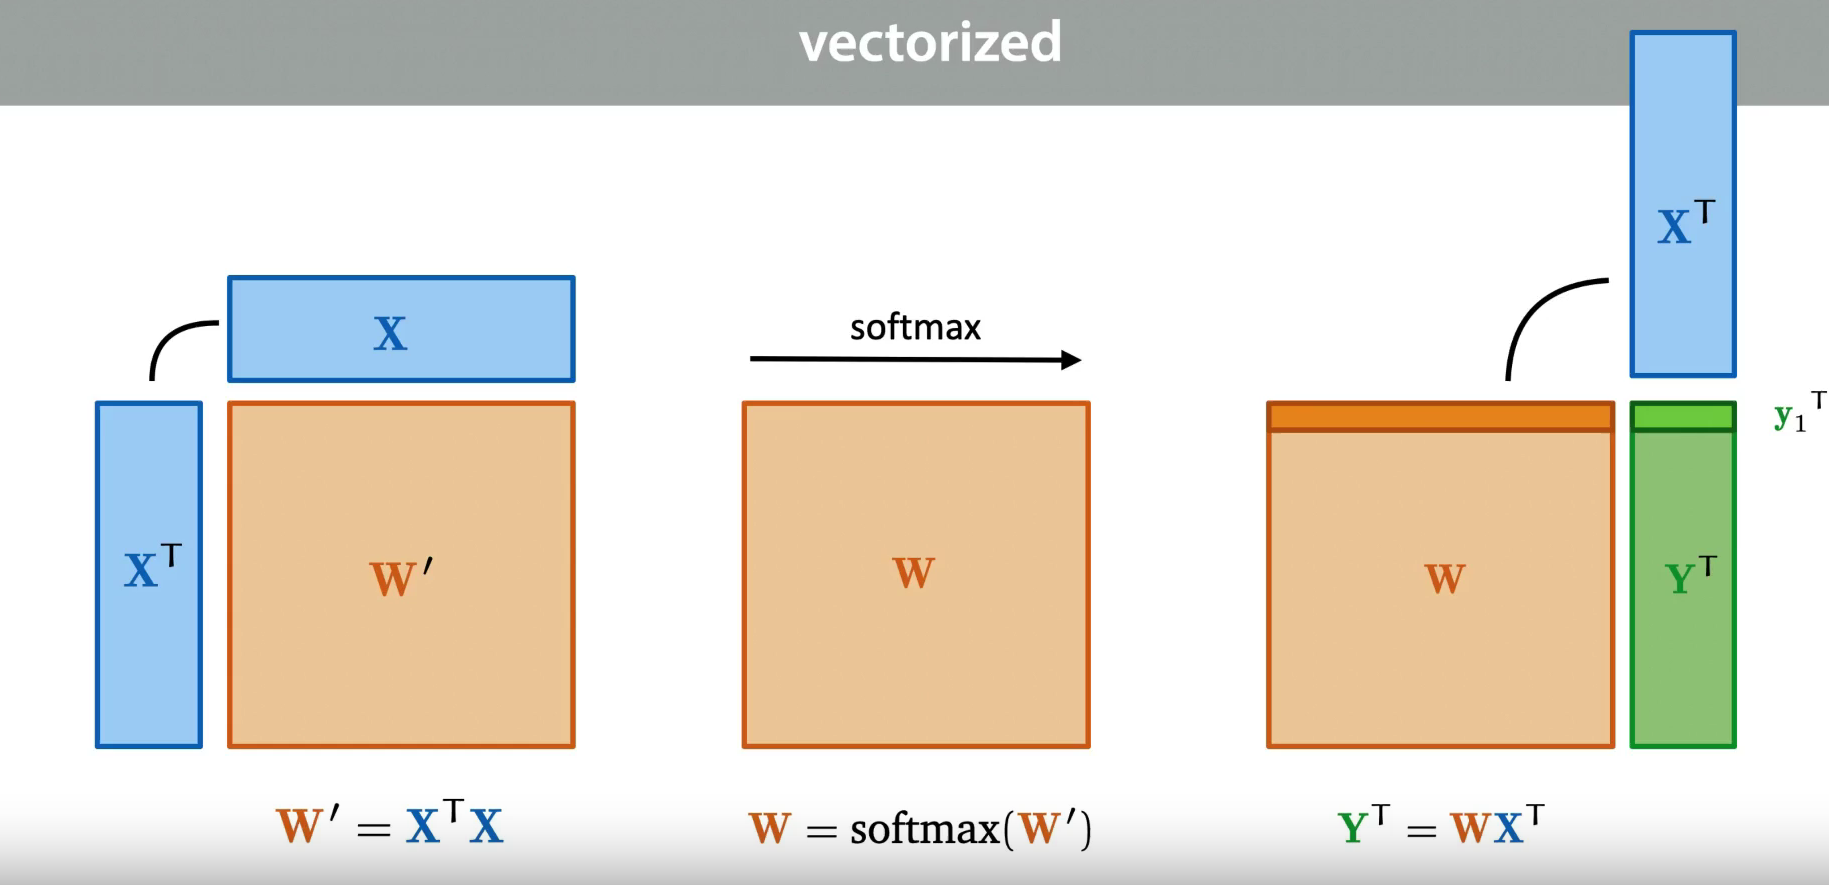

In [21]:
Xy_train_set[0][0].shape


torch.Size([1, 2514])

In [22]:
class SimpleSelfAttentionModelV1(nn.Module):
  def __init__(self, vocab_size,
               emb_size: int,
               output_shape: int,
               padding_idx: int = 0) -> None:

    super().__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=emb_size,
                                  padding_idx=padding_idx
                                  )

    self.linear_layer = nn.Linear(in_features=emb_size,
                                  out_features=output_shape
                                  )

  def forward(self, x: torch.tensor):
    embeddings = self.embedding(x)  # (batch_size, seq_length, emb_size)
    attention_weight_scores = torch.bmm(embeddings,
                                  embeddings.transpose(1, 2))
    attention_weigths = torch.softmax(attention_weight_scores,
                                    dim=2
                                    )
    output_vector = torch.bmm(attention_weigths,
                              embeddings
                              )
    max_pool = torch.max(output_vector, dim=1)[0]

    output = self.linear_layer(max_pool)
    return output

In [23]:
model_0 = SimpleSelfAttentionModelV1(vocab_size=VOCAB_SIZE,
                                     emb_size=EMB_SIZE,
                                     output_shape = numcls).to(device)

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

In [25]:
torch.cuda.manual_seed(22)
epochs = 10
train_time_start_on_gpu = Timer()


for epoch in tqdm(range(epochs)):

  # Train step
  train_step(model=model_0,
             train_data=Xy_train_set,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)
  # Test step
  test_step(model=model_0,
            test_data=Xy_val_set,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end_on_gpu = Timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0305 | Train accuracy 68.90%
Epoch: 0 | Test loss: 0.3726 | Test accuracy 86.75%
Train time on cuda: 25.799 seconds
Epoch: 1 | Train Loss: 0.6646 | Train accuracy 87.30%
Epoch: 1 | Test loss: 0.4307 | Test accuracy 88.20%
Train time on cuda: 50.547 seconds
Epoch: 2 | Train Loss: 0.6742 | Train accuracy 92.09%
Epoch: 2 | Test loss: 0.0988 | Test accuracy 97.66%
Train time on cuda: 75.669 seconds
Epoch: 3 | Train Loss: 0.5405 | Train accuracy 94.44%
Epoch: 3 | Test loss: 0.0984 | Test accuracy 98.34%
Train time on cuda: 100.638 seconds
Epoch: 4 | Train Loss: 0.4181 | Train accuracy 96.49%
Epoch: 4 | Test loss: 0.0969 | Test accuracy 98.51%
Train time on cuda: 125.357 seconds
Epoch: 5 | Train Loss: 0.1503 | Train accuracy 98.28%
Epoch: 5 | Test loss: 0.1748 | Test accuracy 97.76%
Train time on cuda: 150.112 seconds
Epoch: 6 | Train Loss: 0.3816 | Train accuracy 98.16%
Epoch: 6 | Test loss: 0.1076 | Test accuracy 98.73%
Train time on cuda: 174.888 seconds
Epoch: 7 